<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_pandas_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Parquet Derivatives

In this notebook, we'll setup an enviroment, then download a dataset of web archive collection derivatives that were produced with the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). These derivatives are in the [Apache Parquet](https://parquet.apache.org/) format, which is a [columnar storage](http://en.wikipedia.org/wiki/Column-oriented_DBMS) format. These derivatives and generally small enough to work with on your local machine, and can be easily converted to Pandas DataFrames as demostrated below.

**[Binary Analysis](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#binary-analysis)**
- [Audio](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-audio-information)
- [Images](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-image-information)
- [PDFs](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-pdf-information)
- [Presentation program files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-presentation-program-files-information)
- [Spreadsheets](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-spreadsheet-information)
- [Text files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-text-files-information)
- [Videos](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-video-information)
- [Word processor files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-word-processor-files-information)

**Web Pages**

`.webpages()` Produces a DataFrame with the following columns:
  - `crawl_date`
  - `url`
  - `mime_type_web_server`
  - `mime_type_tika`
  - `content`

**Web Graph**

`.webgraph()` Produces a DataFrame with the following columns:
  - `crawl_date`
  - `src`
  - `dest`
  - `anchor`

**Image Links**

`.imageLinks()` Produces a DataFrame with the following columns:
  - `src`
  - `image_url`


# Dataset

We will need a web archive dataset to work with.

The one we'll use in this example notebook comes from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup banq!

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3596786.svg)](https://doi.org/10.5281/zenodo.3596786)


Curious about the size the derivative Parquet output compared to the size of the web archive collection?

The total size of all 11 Parquet deriatives is 1.5G, with `webpages` being the largest (1.4G) since it has a column with all the text.

```
948K	./spreadsheet
3.5M	./image
56K	./audio
1.7M	./word-processor
1.4G	./webpages
2.5M	./video
252K	./text
24M	./webgraph
18M	./imagelinks
16K	./presentation-program
3.2M	./pdf
1.5G	.
```

The total size of the web archive collection is 165G.

In [0]:
%%capture

!curl -L "https://zenodo.org/record/3596786/files/environnement-qc.tar.gz?download=1" > environment-qc-parquet.tar.gz
!tar -xzf environment-qc-parquet.tar.gz

In [4]:
!ls -1 environnement-qc

audio
image
imagelinks
pdf
presentation-program
README
spreadsheet
text
video
webgraph
webpages
word-processor


# Environment

Next, we'll setup our environment so we can work with the Parquet output with Pandas.

In [0]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# Loading our Archives Unleashed Datasets as DataFrames

Next, we'll load up our datasets to work with, and show a preview of each. We'll load the network, domains, web graph, pages, and images. The remainder of the binary datasets (audio, video, spreadsheets, etc.) will all follow the same pattern as the images dataset, except that they do not have the height and width columns.


## Images

In [7]:
images_parquet = pq.read_table('environnement-qc/image')
images = images_parquet.to_pandas()
images



,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
0,http://www.mddelcc.gouv.qc.ca/pesticides/jardi...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
1,http://www.mddep.gouv.qc.ca//pesticides/jardin...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
2,http://www.mddefp.gouv.qc.ca////pesticides/jar...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
3,http://www.mddefp.gouv.qc.ca////pesticides/jar...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
4,http://www.mddep.gouv.qc.ca/pesticides/jardine...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
...,...,...,...,...,...,...,...,...
128294,http://mddep.gouv.qc.ca///biodiversite/habitat...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
128295,http://mddep.gouv.qc.ca//biodiversite/habitats...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
128296,http://www.mddep.gouv.qc.ca/biodiversite/habit...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
128297,http://mddep.gouv.qc.ca////biodiversite/habita...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8


## Web Graph

In [9]:
webgraph_parquet = pq.read_table('environnement-qc/webgraph')
webgraph = webgraph_parquet.to_pandas()
webgraph

,crawl_date,src,dest,anchor
0,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,http://www.mddefp.gouv.qc.ca/communiques/2013/...,Estimation au 24 juillet 2013 des quantit�s de...
1,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,http://recherched.gouv.qc.ca/internet/search.d...,Recherche
2,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,http://www.gouv.qc.ca/,
3,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
4,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,http://recherched.gouv.qc.ca/internet/search.d...,Recherche
...,...,...,...,...
1124520,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2015"
1124521,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,http://www.gouv.qc.ca/,
1124522,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2015"
1124523,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,http://www.gouv.qc.ca/,


## Pages

In [10]:
pages_parquet = pq.read_table('environnement-qc/webpages')
pages = pages_parquet.to_pandas()
pages

,crawl_date,url,mime_type_web_server,mime_type_tika,content
0,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
1,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
2,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
3,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
4,20140509,http://www.mddefp.gouv.qc.ca////infuseur/commu...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
...,...,...,...,...,...
322336,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
322337,20160419,http://www.mddelcc.gouv.qc.ca/publications/199...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
322338,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
322339,20160419,http://www.mddelcc.gouv.qc.ca/publications/200...,text/html,text/html,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...


# Data Analysis

Now that we have all of our datasets loaded up, we can begin to work with it!

## Counting total files, and unique files



#### Count number of rows (how many images are in the web archive collection).


In [11]:
images.count()

url                     128299
filename                128299
extension               128299
mime_type_web_server    128299
mime_type_tika          128299
width                   128299
height                  128299
md5                     128299
dtype: int64

 #### How many unique images are in the collection?




In [12]:
len(images.md5.unique())

9282

#### What are the top 10 most occuring images in the collection?

In [14]:
images['md5'].value_counts().head(10)

e7d1f7750c16bc835bf1cfe1bf322d46    168
5283d313972a24f0e71c47ae3c99958b    168
a4d3ddfb1a95e87650c624660d67765a    168
b09dc3225d5e1377c52c06feddc33bfe    168
497db34fffa0e278f57ae614b4b758a0     54
89663337857f6d769fbcaed7278cc925     52
58e5d8676dfcc4205551314d98fb2624     51
a8e006b69336ea12b293a62b2f9d330f     48
1f5794b728c6a7e101c472eeb30fce60     48
4098b0699d95df5f31a43420ba8e1f87     47
Name: md5, dtype: int64


#### What's the information around all of the occurances of `5283d313972a24f0e71c47ae3c99958b`?


In [15]:
images.loc[images['md5'] == '5283d313972a24f0e71c47ae3c99958b']

,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
86127,http://www.mddefp.gouv.qc.ca//poissons/st-char...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86128,http://www.mddep.gouv.qc.ca/poissons/yamaska/t...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86129,http://mddefp.gouv.qc.ca/poissons/st-maurice/t...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86130,http://mddefp.gouv.qc.ca/poissons/st-francois/...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86131,http://mddefp.gouv.qc.ca/poissons/chateauguay/...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
...,...,...,...,...,...,...,...,...
86290,http://www.mddelcc.gouv.qc.ca//poissons/yamask...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86291,http://www.mddelcc.gouv.qc.ca//poissons/assomp...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86292,http://www.mddelcc.gouv.qc.ca//poissons/st-fra...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
86293,http://www.mddep.gouv.qc.ca/poissons/st-franco...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b


### What does `5283d313972a24f0e71c47ae3c99958b` look like?

We can extract the binary from the web archive using our [binary extraction functions](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/image-analysis.md#scala-df).

```scala
import io.archivesunleashed._
import io.archivesunleashed.matchbox._

val df = RecordLoader
  .loadArchives("example.arc.gz", sc)
  .extractImageDetailsDF();

df.select($"bytes", $"extension")
  .saveToDisk("bytes", "/path/to/export/directory/your-preferred-filename-prefix", $"extension")
```

But! Since we don't have access to the WARC files here, just the Parquet derivatives, we can make do with that by trying to display a live web version of the image, or a replay URL. In this case, BANQ's replay service is available at [https://waext.banq.qc.ca](https://waext.banq.qc.ca).



In [16]:
pd.options.display.max_colwidth = -1
one_image = images.loc[images['md5'] == '5283d313972a24f0e71c47ae3c99958b'].head(1)
one_image['url']

86127    http://www.mddefp.gouv.qc.ca//poissons/st-charles/tumeur.jpg
Name: url, dtype: object

![gross](https://waext.banq.qc.ca/wayback/20121127094123/http://www.mddefp.gouv.qc.ca/poissons/assomption/tumeur.jpg)

#### What are the top 10 most occuring filenames in the collection?



In [17]:
top_filenames = images['filename'].value_counts().head(10)
top_filenames

carte-p.jpg      1144
carte2.jpg       811 
carte1.jpg       769 
carte-g.jpg      630 
carte-qc.jpg     506 
carte-an.jpg     506 
carte.jpg        481 
carte-G.jpg      462 
carte_p.jpg      426 
carte_web.jpg    386 
Name: filename, dtype: int64

#### Let's plot it!

Text(0, 0.5, 'Count')

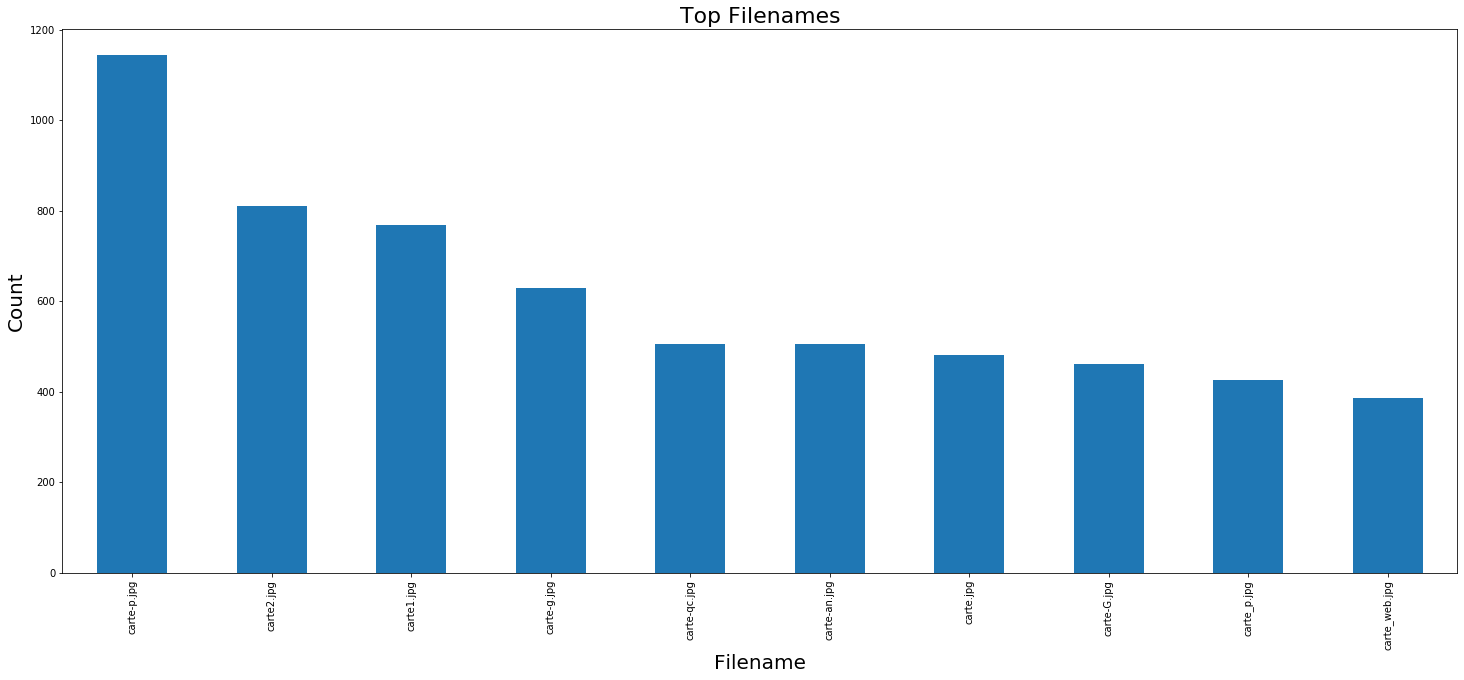

In [18]:
top_filenames_chart = top_filenames.plot.bar(figsize=(25,10))
top_filenames_chart.set_title("Top Filenames", fontsize=22)
top_filenames_chart.set_xlabel("Filename", fontsize=20)
top_filenames_chart.set_ylabel("Count", fontsize=20)

#### How about a MIME type distribution?



Text(0, 0.5, 'Count')

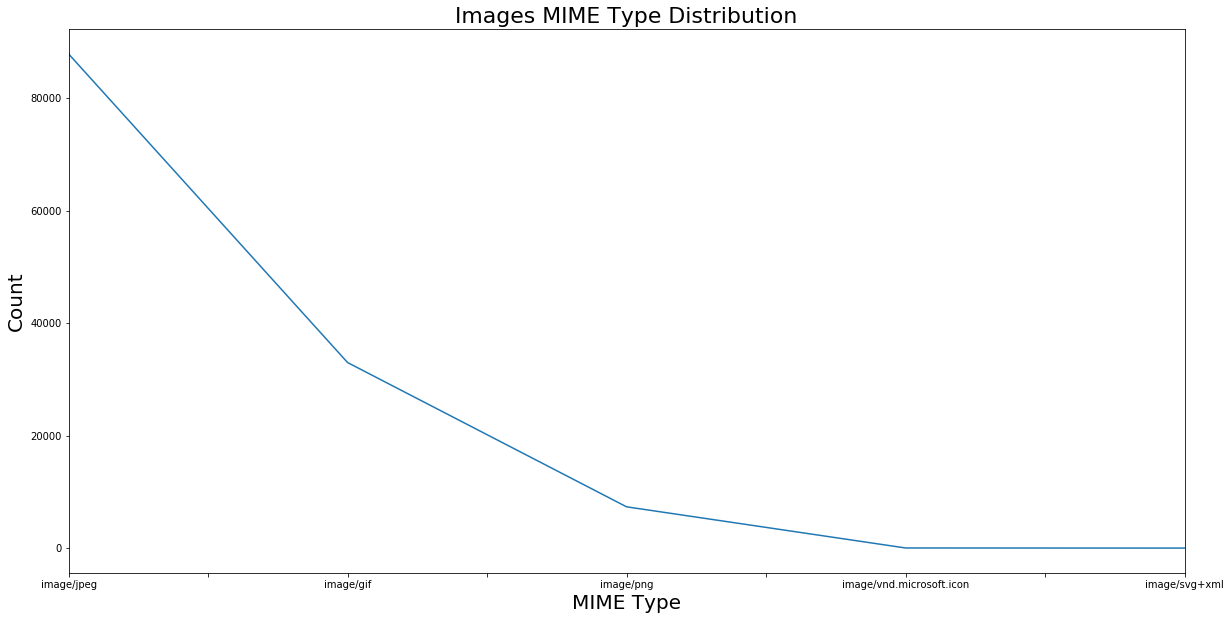

In [19]:
image_mime_types = images['mime_type_tika'].value_counts().head(5)
image_mime_type_chart = image_mime_types.plot.line(figsize=(20,10))
image_mime_type_chart.set_title("Images MIME Type Distribution", fontsize=22)
image_mime_type_chart.set_xlabel("MIME Type", fontsize=20)
image_mime_type_chart.set_ylabel("Count", fontsize=20)

Text(0, 0.5, 'Count')

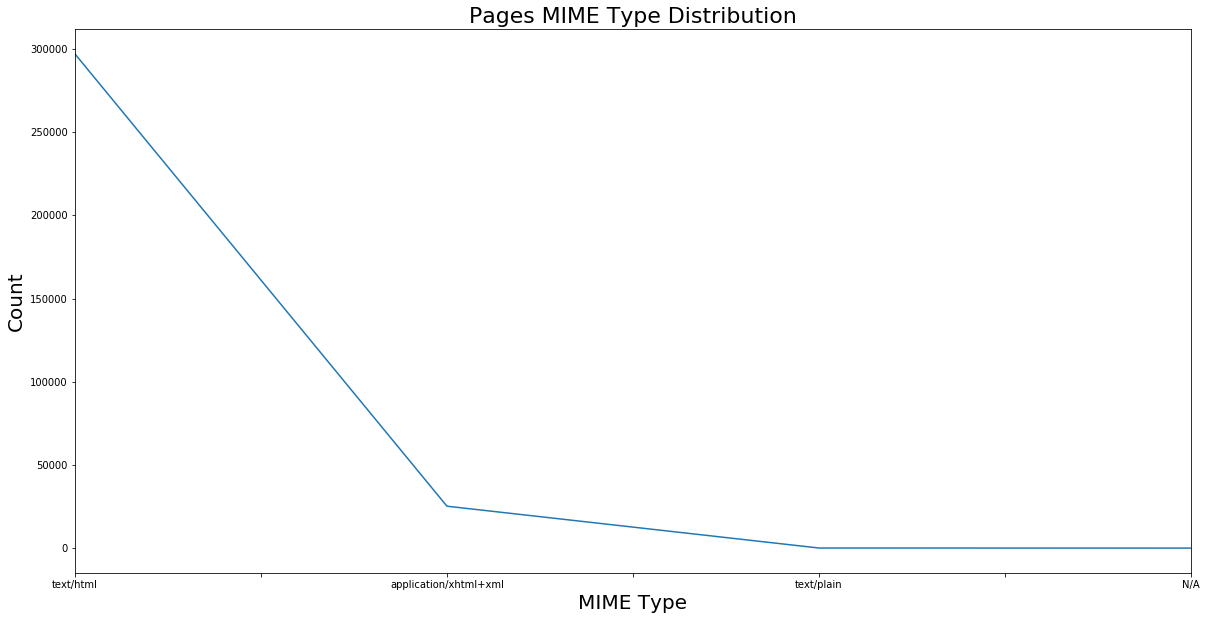

In [20]:
page_mime_types = pages['mime_type_tika'].value_counts()
page_type_chart = page_mime_types.plot.line(figsize=(20,10))
page_type_chart.set_title("Pages MIME Type Distribution", fontsize=22)
page_type_chart.set_xlabel("MIME Type", fontsize=20)
page_type_chart.set_ylabel("Count", fontsize=20)

## Domains

In [21]:
# domains_parquet = pq.read_table('environnement-qc/domains')
# domains = domains_parquet.to_pandas()
domains = pages.apply(lambda row: tldextract.extract(row.url).domain, axis=1)

OSError: ignored

#### Let's start off here by creating a line chart of the top 10 domains.

Text(0, 0.5, 'Count')

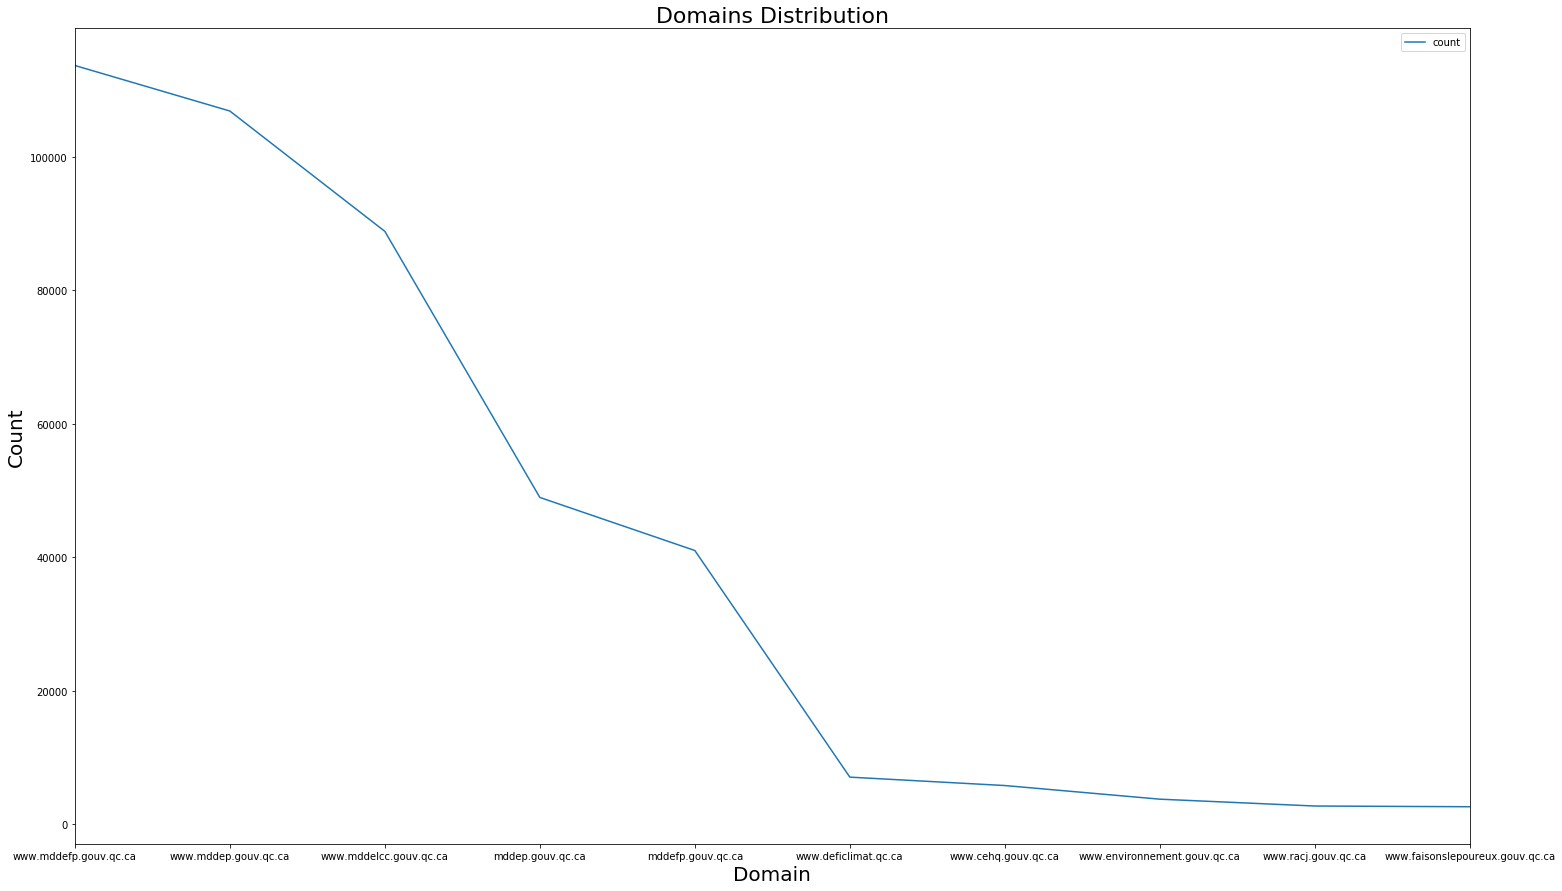

In [0]:
top_domains = domains.sort_values('count', ascending=False).head(10)
top_domains_chart = top_domains.plot.line(x='Domain', y='count', figsize=(25,15))
top_domains_chart.set_title("Domains Distribution", fontsize=22)
top_domains_chart.set_xlabel("Domain", fontsize=20)
top_domains_chart.set_ylabel("Count", fontsize=20)

### Top Level Domain Analysis
Next, we'll be creating a new column, `tld`, which is based off an existing column, 'Domain'. This example should give you an idea of how you can expand these datasets to do further research and analysis.

We'll take the `Domain` column, and extract the `tld` from it with [`tldextract`](https://github.com/john-kurkowski/tldextract).

First we'll add the [`tldextract`](https://github.com/john-kurkowski/tldextract)library to the notebook. Then, we'll create the new column.

In [0]:
%%capture

!pip install tldextract

In [0]:
import tldextract

domains['tld'] = domains.apply(lambda row: tldextract.extract(row.Domain).suffix, axis=1)
domains

,Domain,count,tld
0,www.mddefp.gouv.qc.ca,113680,qc.ca
1,www.mddep.gouv.qc.ca,106857,qc.ca
2,www.mddelcc.gouv.qc.ca,88832,qc.ca
3,mddep.gouv.qc.ca,48971,qc.ca
4,mddefp.gouv.qc.ca,41023,qc.ca
5,www.deficlimat.qc.ca,7073,qc.ca
6,www.cehq.gouv.qc.ca,5814,qc.ca
7,www.environnement.gouv.qc.ca,3771,qc.ca
8,www.racj.gouv.qc.ca,2746,qc.ca
9,www.faisonslepoureux.gouv.qc.ca,2639,qc.ca


#### Next, let's count the distict TLDs.


In [0]:
tld_count = domains['tld'].value_counts()
tld_count

qc.ca    131
com       87
org       34
ca        33
gc.ca     10
gov        8
net        6
co.kr      4
int        3
ch         3
be         2
edu        1
info       1
eu         1
tv         1
sk.ca      1
Name: tld, dtype: int64

#### Next, we'll plot the TLD count.


Text(0.5, 1.0, 'Top Level Domain Distribution')

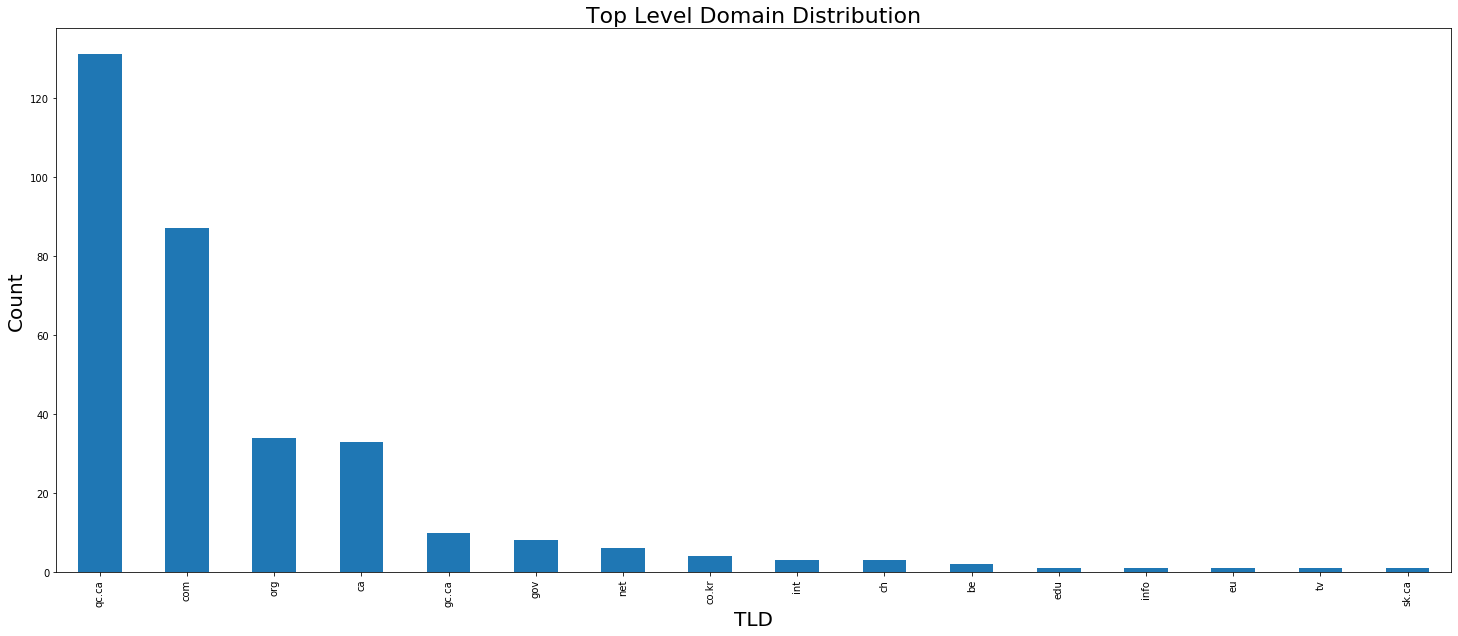

In [0]:
tld_chart = tld_count.plot.bar(legend=None, figsize=(25,10))
tld_chart.set_xlabel("TLD", fontsize=20)
tld_chart.set_ylabel("Count", fontsize=20)
tld_chart.set_title("Top Level Domain Distribution", fontsize=22)

## Text Analysis

With the `pages` derivative, we get a `text` column. This is the text of the web page, we the HTTP header information stripped out. Since we have this column, it opens up the whole world of text analysis to us!

Note of caution here, working with raw text can be very memory intensive, and we're limited on memory in Colab. You'll need to set up an enviroment with more memory if you want to do analysis on larger collection. In these examples, you might notice us using `.head()` on some examples. This is because we can't load all of the text for some of the examples.

Let's start the text analysis section by installing and importing [`textblob`](https://textblob.readthedocs.io/en/dev/), a really robust text processing Python library, and download some helpful items from [`nltk`](https://www.nltk.org/).

In [0]:
%%capture

!pip install textblob
!python -m nltk.downloader all

import nltk
from textblob import TextBlob

### Tokenization

Let's add a new column to our `pages` DataFrame that is the tokenized output of the `text` column.

**THIS TAKES A LONG TIME**

In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize

pages['tokenized_text'] = pages.apply(lambda row: word_tokenize(row.content), axis=1)
pages

#### Let's add one more column, a count of tokenized words.

In [0]:
pages['tokenized_text_count'] = pages.apply(lambda row: len(row.tokenized_text), axis=1)
pages

### Basic word count statistics

In [0]:
pages['tokenized_text_count'].mean()

In [0]:
pages['tokenized_text_count'].std()

In [0]:
pages['tokenized_text_count'].max()

In [0]:
pages['tokenized_text_count'].min()

### Pages with the most words

Let's create a bar chart, that shows the pages with the most words.

First, let's show the query to get the data for our chart.




In [0]:
word_count = pages[['url', 'tokenized_text_count']].sort_values(by='tokenized_text_count', ascending=False).head(25)
word_count

Next, let's create a bar chart of this.

In [0]:
word_count_chart = word_count.plot(kind='bar', x='url', figsize=(20,10))
word_count_chart.set_title('Pages with most words\n', fontsize=22)
word_count_chart.set_ylabel('Count', fontsize=20)
word_count_chart.set_xlabel('Page', fontsize=20)


### Sentiment Analysis

Let's start with sentiment analysis.


In [0]:
text_blob = TextBlob("".join(pages['text'].head(10000).values))
text_blob.sentiment

### n-grams

In [0]:
from nltk.util import ngrams

ngrams(text_blob, 5)

### Word Cloud

Word clouds are always fun, right?!

Let's setup some dependcies here, and install the [`word_cloud`](https://github.com/amueller/word_cloud) library, and setup some stop words via `nltk`.


In [0]:
%%capture

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

french_stop_words = set(stopwords.words('french'))

In [0]:
wordcloud = WordCloud(stopwords=french_stop_words, width=2000, height=1500, scale=10, max_font_size=250, max_words=100, background_color="white").generate("".join(pages['text'].values))
plt.figure(figsize=[35,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Examining the Web Graph

Let's start by looking at the web graph columns again.

In [0]:
webgraph

### What are the most frequent crawl dates?


In [0]:
crawl_dates = webgraph['crawl_date'].value_counts()
crawl_dates
crawl_dates_chart = crawl_dates.plot.line(figsize=(25,12))
crawl_dates_chart.set_xlabel("Crawl Date", fontsize=20)
crawl_dates_chart.set_ylabel("Count", fontsize=20)
crawl_dates_chart.set_title("Crawl Date Frequency", fontsize=22)
